In [1]:
import numpy as np
import cv2
import time
import struct
import math
from os import listdir
from ipywidgets import interact
from skimage import io
from skimage import color
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pydicom
from pydicom.datadict import dictionary_VR
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
from pydicom.dataset import Dataset, FileDataset

def pokaż(img, size=15, aspect=1):
    fig = plt.figure(figsize=(size,size))
    plt.imshow(img, aspect=aspect)
    plt.show()  

# Algorytm Bresenhama

In [2]:
def zamalujPixel(img, i, j, maxY, jasność):
    img[maxY-j-1][i] += jasność
    
def wartośćPiksela(img, i, j, maxY, paramter):
    return img[maxY-j-1][i]
    
def bresenham(img, maxX, maxY, x1, y1, x2, y2, funkcja, parametr = 0):
    if((y2 - y1) < -(x2 - x1)):
        #kolejność punktów: 2, 1
        if y2 - y1 <= x2 - x1:
            return bresenham2(img, maxY, maxX, y2, x2, y1, x1, True, funkcja, parametr) #DA = Y
        else:
            return bresenham2(img, maxX, maxY, x2, y2, x1, y1, False, funkcja, parametr) #DA = x
    else:
        #kolejność punktów: 1, 2
        if y2 - y1 <= x2 - x1:
            return bresenham2(img, maxX, maxY, x1, y1, x2, y2, False, funkcja, parametr) #DA = x
        else:
            return bresenham2(img, maxY, maxX, y1, x1, y2, x2, True, funkcja, parametr) #DA = Y
            
def bresenham2(img, maxX, maxY, x1, y1, x2, y2, odwróć, funkcja, parametr):
    wyniki = []
    m = (y2 - y1)/(x2 - x1)
    direction = -1 if m < 0 else 1
    i1 = math.floor(x1)
    j = math.floor(y1)
    i2 = math.floor(x2)
    e = -direction*(1- (y1-j) - (y2 - y1)*(1-(x1-i1))/(x2 - x1))
    
    for i in range(i1, i2):
        if i < maxX and i > 0 and j<maxY and j > 0:
            if odwróć:
                wyniki.append(funkcja(img, j, i, maxX, parametr))
            else:
                wyniki.append(funkcja(img, i, j, maxY, parametr))
        if (e >= 0):
            j += 1*direction #jak maleje to odejmuje
            e -= 1
        e += m*direction #poprawianie na zawsze dodatnie m, żeby zawsze mieć dodatnie e
    return wyniki

# Deklaracja funkcji transformaty Radona i transformaty odwrotnej

In [3]:
def obliczSinogram(obrazWej, deltaAlpha = math.pi/20, ilośćEmiterów = 100, rozpiętość = 3):
    maxX = obrazyWielkości[obrazId][0]
    maxY = obrazyWielkości[obrazId][1]
    
    print('Wykonywanie transformaty Radona:')
    start = time.time()
    sinogramy = []
    
    sinogram = np.zeros((ilośćEmiterów+1, int(np.floor(math.pi/deltaAlpha))+1))
    alpha = 0
    r = min(maxX/2, maxY/2)
    s = (maxY/2, maxX/2)

    i=0
    procent = 0
    while alpha > -math.pi:
        #wyświetlanie procentów wykonania
        while (100*i)/int(math.pi/deltaAlpha) > procent: 
            procent += 10
            print(procent, "%", sep = '')
            
        #wykonywanie skanu w danej pozycji alpha
        j=0
        for d in np.arange(-rozpiętość/2, rozpiętość/2, rozpiętość/ilośćEmiterów):
            x1 = r*math.cos(alpha +d) + s[0]
            y1 = r*math.sin(alpha +d) + s[1]
            x2 = r*math.cos(alpha +math.pi -d) + s[0]
            y2 = r*math.sin(alpha +math.pi -d) + s[1]
            sinogram[j][i] = np.sum(bresenham(obrazWej, maxY, maxX, x1, y1, x2, y2, wartośćPiksela))
            j+=1
            
        sinogramy.append(sinogram/1)
        alpha -= deltaAlpha
        i+=1
        
    end = time.time()
    print("Koniec, czas wykonania", round(end - start, 2), "sekund")
    return sinogramy

def obliczObrazWyjściowy(sinogram, deltaAlpha = math.pi/20, ilośćEmiterów = 100, rozpiętość = 3):
    maxX = obrazyWielkości[obrazId][0]
    maxY = obrazyWielkości[obrazId][1]
    
    print('Wykonywanie odwrotnej transformaty Radona:')
    start = time.time()
    obrazyWyj = []
    
    obrazWyjściowy = np.zeros((maxX, maxY))
    alpha = 0
    r = min(maxX/2, maxY/2)
    s = (maxY/2, maxX/2)

    i=0
    procent = 0
    while alpha > -math.pi:
        #wyświetlanie procentów wykonania co 10%
        while (100*i)/int(math.pi/deltaAlpha) > procent: 
            procent += 10
            print(procent, "%", sep = '')
            
        #wykonywanie skanu wszystkich linii w danej pozycji emitera = alpha
        j=0
        for d in np.arange(-rozpiętość/2, rozpiętość/2, rozpiętość/ilośćEmiterów):
            x1 = r*math.cos(alpha +d) + s[0]
            y1 = r*math.sin(alpha +d) + s[1]
            x2 = r*math.cos(alpha +math.pi -d) + s[0]
            y2 = r*math.sin(alpha +math.pi -d) + s[1]
            bresenham(obrazWyjściowy, maxY, maxX, x1, y1, x2, y2, zamalujPixel, sinogram[j][i])
            j+=1
        
        mina = np.min(obrazWyjściowy)
        maxa = np.max(obrazWyjściowy)
        obrazWyjściowyNorm = (obrazWyjściowy-mina)/(maxa-mina) #normalizacja wartości obrazu
        obrazyWyj.append(obrazWyjściowyNorm)
        alpha -= deltaAlpha
        i+=1
        
    end = time.time()
    print("Koniec, czas wykonania", round(end - start, 2), "sekund")
    return obrazyWyj


# Operacje na plikach DICOM

In [4]:
def pobierzWartość(dicom, id):
    try:
        return dicom[id].value
    except KeyError:
        return ""
    
def wypiszDane(kluczeDanych, dane, początek = ""):
    for i in range (0, len(kluczeDanych)):
        print(początek, kluczeDanych[i][0], ':', dane[i])

def ustawWartość(dicom, id, wartość):
    if wartość == '':
        try:
            del dicom[id]
        except KeyError:
            ;
    else:
        try:
            dicom[id].value = wartość
        except KeyError:
            dicom.add_new(id, dictionary_VR(id), wartość)
    
def pobierzDane(dicom, kluczeDanych):
    dane = []
    for i in range (0, len(kluczeDanych)):
        dane.append(pobierzWartość(dicom, kluczeDanych[i][1]))
    return dane
    
def zapiszDane(dicom, kluczeDanych, dane):
    for i in range (0, len(kluczeDanych)):
        ustawWartość(dicom, kluczeDanych[i][1], dane[i])

def zróbDICOM():
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian 

    dicom = FileDataset(None, {}, preamble=b"\0" * 128)
    dicom.file_meta = meta
    
    dicom.is_little_endian = True
    dicom.is_implicit_VR = False

    dicom.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    dicom.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    return dicom
        
def wczytajDICOM(plik):
    dicom = pydicom.dcmread(plik)
    return dicom

def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def zapiszDIDOM(plik, dicom, obraz):
    img_converted = convert_image_to_ubyte(obraz)    

    dicom.Modality = "CT"
    dicom.SeriesInstanceUID = pydicom.uid.generate_uid()
    dicom.StudyInstanceUID = pydicom.uid.generate_uid()
    dicom.FrameOfReferenceUID = pydicom.uid.generate_uid()

    dicom.BitsStored = 8
    dicom.BitsAllocated = 8
    dicom.SamplesPerPixel = 1
    dicom.HighBit = 7

    dicom.ImagesInAcquisition = 1
    dicom.InstanceNumber = 1

    dicom.Rows, dicom.Columns = img_converted.shape

    dicom.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    dicom.PhotometricInterpretation = "MONOCHROME2"
    dicom.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(dicom.file_meta, enforce_standard=True)

    dicom.PixelData = img_converted.tobytes()
    dicom.save_as(plik, write_like_original=False)

# Wczytywanie plików

#### Lokalizacja obrazów lub plików DICOM i klucze tagów DICOM z przyjaznymi nazwami

In [5]:
lokalizacja = 'pliki'
kluczeDanych = [('nazwisko', (0x0010, 0x0010)), 
                ('id', (0x0010, 0x0020)), 
                ('data',((0x0008, 0x0012))), 
                ('godzina',((0x0008, 0x0013))), 
                ('komentarz',((0x0020, 0x4000)))]

#### Wykonanie

In [6]:
start = time.time()
nazwyPlików = listdir(lokalizacja)
dicoms = []
dane = []
obrazy = []
obrazyWielkości = []

for nazwa in nazwyPlików:
    print("wczytywanie", len(obrazy), nazwa)
    
    if nazwa[-4:].lower() == ".dcm":
        dicoms.append(wczytajDICOM(lokalizacja+"/"+nazwa))
        dane.append(pobierzDane(dicoms[-1], kluczeDanych))
        
        obrazy.append(dicoms[-1].pixel_array/255)
    else:
        dicoms.append(zróbDICOM())
        dane.append(pobierzDane(dicoms[-1], kluczeDanych))
        obrazy.append(io.imread(lokalizacja+"/"+nazwa)/255)
    
    wypiszDane(kluczeDanych, dane[-1], początek = "\t")
    obrazyWielkości.append(np.shape(obrazy[-1]))
    
    if len(obrazyWielkości[-1]) == 3:
        obrazy[-1] = obrazy[-1][:, :, 0]
        obrazyWielkości[-1] = np.shape(obrazy[-1]) 
        
end = time.time()
print("Koniec, czas wykonania", round(end - start, 2), "sekund")

wczytywanie 0 CT_ScoutView-large.dcm
	 nazwisko : Doe^John
	 id : 42
	 data : 
	 godzina : asdasdasdasdxx
	 komentarz : what a lovely image we have here...
wczytywanie 1 CT_ScoutView-large.jpg
	 nazwisko : 
	 id : 
	 data : 
	 godzina : 
	 komentarz : 
wczytywanie 2 CT_ScoutView.dcm
	 nazwisko : Doe^John
	 id : 42
	 data : 
	 godzina : asdasdasdasdxx
	 komentarz : what a lovely image we have here...
wczytywanie 3 CT_ScoutView.jpg
	 nazwisko : 
	 id : 
	 data : 
	 godzina : 
	 komentarz : 
wczytywanie 4 Kolo.dcm
	 nazwisko : Doe^John
	 id : 42
	 data : 
	 godzina : asdasdasdasdxx
	 komentarz : what a lovely image we have here...
wczytywanie 5 Kolo.jpg
	 nazwisko : 
	 id : 
	 data : 
	 godzina : 
	 komentarz : 
wczytywanie 6 Kropka.dcm
	 nazwisko : Doe^John
	 id : 42
	 data : 
	 godzina : asdasdasdasdxx
	 komentarz : what a lovely image we have here...
wczytywanie 7 Kropka.jpg
	 nazwisko : 
	 id : 
	 data : 
	 godzina : 
	 komentarz : 
wczytywanie 8 Kwadraty2.dcm
	 nazwisko : Doe^John
	 

# Wykonanie transformaty Radona i transformaty odwrotnej

#### Parametry wejściowe

In [7]:
obrazId = 16
deltaAlpha = math.pi/180
ilośćEmiterów = 180
rozpiętośćEmiterow = 0.99*math.pi
wielkośćRozmycia = 15

#### Wykonanie

Obraz wejściowy:


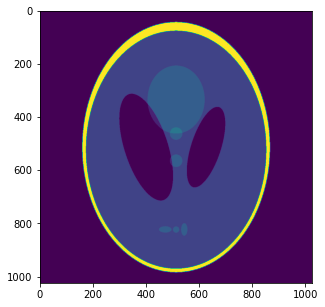

Wykonywanie transformaty Radona:
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
Koniec, czas wykonania 15.96 sekund
Sinogram:


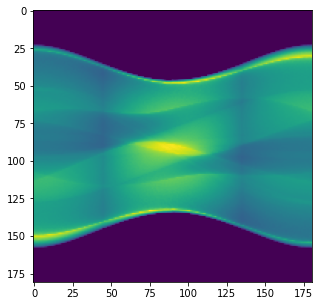

Wykonywanie odwrotnej transformaty Radona:
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
Koniec, czas wykonania 18.68 sekund
Obraz wyjściowy:


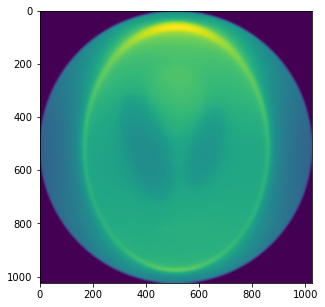

In [8]:
obrazWej = obrazy[obrazId]
print("Obraz wejściowy:")
pokaż(obrazWej, 5)

sinogramy = obliczSinogram(obrazWej, deltaAlpha, ilośćEmiterów, rozpiętośćEmiterow)
print("Sinogram:")
pokaż(sinogramy[-1], 5, 'auto')

obrazyWyj = obliczObrazWyjściowy(sinogramy[-1], deltaAlpha, ilośćEmiterów, rozpiętośćEmiterow)
print("Obraz wyjściowy:")
pokaż(cv2.GaussianBlur(obrazyWyj[-1],(wielkośćRozmycia,wielkośćRozmycia),cv2.BORDER_DEFAULT), 5)

# Wyświetlanie wyników - obraz wejściowy, sinogram, obraz wyjściowy

In [9]:
def obrazWejściowyFun(rozmiar = 5):
    print('Sinogram:')
    pokaż(obrazWej, rozmiar) #wyświetlenie

def sinogramFun(krok = 0, rozmiar = 5):
    print('Sinogram:')
    pokaż(sinogramy[krok], rozmiar, 'auto') #wyświetlenie

def obrazWyjściowyFun(krok = 0, rozmiar = 5, rozmycie=9, odc_dolne = 0, odc_górne = 1):
    print('Obraz wyjściowy:')
    img = cv2.GaussianBlur(obrazyWyj[krok],(rozmycie,rozmycie),cv2.BORDER_DEFAULT) #rozmycie gaussa
    mina = np.min(img)
    maxa = np.max(img)
    img = (img-mina)/(maxa-mina) #normalizacja wartości obrazu
    img = np.clip(img, odc_dolne, odc_górne) #stosowanie odcięcia najmniejszych i najwiekszych wartości
    pokaż(img, rozmiar) #wyświetlenie

    
    
print('Obraz wejściowy:')
interact(obrazWejściowyFun, rozmiar=(1,15,1));

print('Parametry wyświetlania sinogramu:')
interact(sinogramFun, krok=(0,len(sinogramy)-1,1), rozmiar=(1,15,1));

print('Parametry wyświetlania obrazu wyjściowego:')
interact(obrazWyjściowyFun, krok=(0,len(obrazyWyj)-1,1), rozmiar=(1,15,1), rozmycie=(1,101,2),  odc_dolne=(0,1,0.05), odc_górne=(0,1,0.05));

Obraz wejściowy:


interactive(children=(IntSlider(value=5, description='rozmiar', max=15, min=1), Output()), _dom_classes=('widg…

Parametry wyświetlania sinogramu:


interactive(children=(IntSlider(value=0, description='krok', max=180), IntSlider(value=5, description='rozmiar…

Parametry wyświetlania obrazu wyjściowego:


interactive(children=(IntSlider(value=0, description='krok', max=180), IntSlider(value=5, description='rozmiar…

# Zapisywanie wyników w pliku DICOM

#### Dane odczytane z wejściowego pliku DICOM

In [10]:
wypiszDane(kluczeDanych, dane[obrazId])

 nazwisko : Doe^John
 id : 42
 data : 
 godzina : asdasdasdasdxx
 komentarz : what a lovely image we have here...


#### Modyfikacja danych

In [11]:
zmianaDanych = True
nazwisko = 'Nowak Jan'
id = '1234'
rok = 1999
miesiąc = 9
dzień = 23
godzina = 21
minuta = 37
sekunda = 10
komentarz = 'Paski tylko okragle.'

#### Lokalizacja pliku wynikowego

In [12]:
lokalizacjaWyjściowa = 'wyniki'
nazwaPliku = ''

#### Wykonanie zapisu do pliku

In [13]:
if zmianaDanych:
    dane[obrazId] = [nazwisko, 
                     str(id).zfill(1), 
                     str(rok).zfill(4)+str(miesiąc).zfill(2)+str(dzień).zfill(2), 
                     str(godzina).zfill(2)+str(minuta).zfill(2)+str(sekunda).zfill(2), 
                     komentarz]
if nazwaPliku == '':
    nazwaPliku = nazwyPlików[obrazId][:-4] +'.dcm'
zapiszDane(dicoms[obrazId], kluczeDanych, dane[obrazId])
zapiszDIDOM(lokalizacjaWyjściowa+'/'+nazwaPliku, 
            dicoms[obrazId], 
            cv2.GaussianBlur(obrazyWyj[-1],(wielkośćRozmycia,wielkośćRozmycia),cv2.BORDER_DEFAULT))